In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/processed_data.csv")
df_encuestas = pd.read_csv("../data/encuestas.csv")
# === Procesamiento de fechas ===
df["createdAt"] = pd.to_datetime(df["createdAt"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
df["date"] = df["createdAt"].dt.floor("D")
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"]).dt.tz_localize(None)

/tmp/ipykernel_127201/3492966212.py:1: DtypeWarning: Columns (5,19,29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed_data.csv")


In [3]:
# === Agregación diaria ===
df_daily = df.groupby("date", as_index=False).agg({
    "score_positive": "mean",
    "score_negative": "mean",
    "score_neutral": "mean",
    "retweetCount": "mean",
    "replyCount": "mean",
    "likeCount": "mean",
    "quoteCount": "mean",
    **{f"robertuito_{i}": "mean" for i in range(768)}
})

# === Agregación ponderada por engagement ===
def weighted_avg(values, weights):
    return (values * weights).sum() / weights.sum() if weights.sum() != 0 else values.mean()

weighted_features = []
for var in ["retweetCount", "replyCount", "likeCount", "quoteCount"]:
    df_w = df.groupby("date").apply(lambda x: pd.Series({
        f"weighted_positive_{var}": weighted_avg(x["score_positive"], x[var]),
        f"weighted_negative_{var}": weighted_avg(x["score_negative"], x[var]),
        f"weighted_neutral_{var}": weighted_avg(x["score_neutral"], x[var])
    })).reset_index()
    weighted_features.append(df_w)

df_weighted_all = weighted_features[0]
for df_w in weighted_features[1:]:
    df_weighted_all = df_weighted_all.merge(df_w, on="date", how="left")
df_daily = df_daily.merge(df_weighted_all, on="date", how="left")

# === Asignar valores CADEM desde domingo hasta sábado ===

start_date = df_encuestas["date"].min()
end_date = df_encuestas["date"].max() + pd.Timedelta(days=6)
df_cadem_expandido = pd.DataFrame({"date": pd.date_range(start=start_date, end=end_date, freq="D")})
df_cadem_expandido["semana_objetivo"] = df_cadem_expandido["date"].apply(
    lambda d: d + pd.to_timedelta(6 - d.weekday(), unit="D")
)
df_encuestas_ren = df_encuestas.rename(columns={"date": "semana_objetivo"})
df_cadem_expandido = df_cadem_expandido.merge(df_encuestas_ren, on="semana_objetivo", how="left")
df_daily = df_daily.merge(df_cadem_expandido[["date", "aprobacion_boric", "desaprobacion_boric"]], on="date", how="left")

# === Variables derivadas ===
df_daily = df_daily.sort_values("date").reset_index(drop=True)
df_daily["approval_rolling_7d"] = df_daily["aprobacion_boric"].shift(1).rolling(window=7, min_periods=7).mean().fillna(method="ffill")
df_daily["approval_lag_7d"] = df_daily["aprobacion_boric"].shift(7)
df_daily["approval_lag_14d"] = df_daily["aprobacion_boric"].shift(14)

df_daily["disapproval_rolling_7d"] = df_daily["desaprobacion_boric"].shift(1).rolling(window=7, min_periods=7).mean().fillna(method="ffill")
df_daily["disapproval_lag_7d"] = df_daily["desaprobacion_boric"].shift(7)
df_daily["disapproval_lag_14d"] = df_daily["desaprobacion_boric"].shift(14)

for lag in range(1, 8):
    df_daily[f"score_positive_lag_{lag}"] = df_daily["score_positive"].shift(lag)
    df_daily[f"score_negative_lag_{lag}"] = df_daily["score_negative"].shift(lag)
    df_daily[f"score_neutral_lag_{lag}"] = df_daily["score_neutral"].shift(lag)

df_daily["score_negative_rolling7"] = df_daily["score_negative"].rolling(window=7, min_periods=7).mean()
df_daily["score_negative_rolling3"] = df_daily["score_negative"].rolling(window=3, min_periods=3).mean()
df_daily["sentiment_net"] = df_daily["score_positive"] - df_daily["score_negative"]
df_daily["sentiment_net_rolling3"] = df_daily["sentiment_net"].rolling(window=3, min_periods=3).mean()
df_daily["sentiment_net_rolling7"] = df_daily["sentiment_net"].rolling(window=7, min_periods=7).mean()
df_daily["sentiment_net_rolling14"] = df_daily["sentiment_net"].rolling(window=14, min_periods=14).mean()
df_daily["sentiment_net_change"] = df_daily["sentiment_net"] - df_daily["sentiment_net"].shift(1)

# === Resultado final ===
df_daily.tail(20)

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling3,sentiment_net_rolling7,sentiment_net_rolling14,sentiment_net_change
1142,2025-04-16,0.045629,0.675566,0.278805,29.900000,3.950000,80.650000,0.300000,0.280603,0.393599,...,0.217047,0.344908,0.438045,0.502899,0.517871,-0.629938,-0.389425,-0.370457,-0.280470,-0.264189
1143,2025-04-17,0.100585,0.563863,0.335552,15.494253,2.804598,78.011494,1.551724,0.123330,0.449426,...,0.138421,0.322291,0.539288,0.537410,0.577848,-0.463278,-0.486321,-0.410373,-0.304710,0.166660
1144,2025-04-18,0.121163,0.561869,0.316968,105.389474,55.484211,283.757895,6.957895,0.106784,0.500454,...,0.124856,0.555379,0.319765,0.538337,0.600433,-0.440706,-0.511307,-0.411828,-0.314147,0.022572
1145,2025-04-19,0.115589,0.569655,0.314755,60.976471,10.282353,139.611765,2.400000,0.091602,0.475883,...,0.142172,0.547127,0.310701,0.541555,0.565129,-0.454066,-0.452683,-0.418844,-0.341988,-0.013360
1146,2025-04-20,0.063680,0.688488,0.247833,89.452381,42.488095,159.702381,5.130952,0.163606,0.382131,...,0.136304,0.541885,0.321811,0.562498,0.606671,-0.624808,-0.506527,-0.450162,-0.370635,-0.170742
1147,2025-04-21,0.159587,0.470370,0.370042,22.000000,4.372093,108.523256,0.906977,0.070496,0.516010,...,0.211345,0.383933,0.404722,0.574847,0.576171,-0.310783,-0.463219,-0.469904,-0.358397,0.314025
1148,2025-04-22,0.190865,0.389654,0.419482,19.329268,4.695122,67.085366,0.731707,0.123870,0.445961,...,0.128366,0.494115,0.377519,0.559924,0.516171,-0.198789,-0.378127,-0.446053,-0.372392,0.111994
1149,2025-04-23,0.216715,0.374424,0.408862,20.186667,6.293333,69.946667,0.880000,0.125324,0.375660,...,0.045629,0.675566,0.278805,0.516903,0.411483,-0.157709,-0.222427,-0.378591,-0.374524,0.041080
1150,2025-04-24,0.091609,0.569376,0.339014,17.674419,5.046512,41.534884,0.744186,0.175232,0.438198,...,0.100585,0.563863,0.335552,0.517691,0.444485,-0.477767,-0.278088,-0.380661,-0.395517,-0.320058
1151,2025-04-25,0.202168,0.415782,0.382049,102.438356,64.876712,272.780822,9.452055,0.092862,0.454071,...,0.121163,0.561869,0.316968,0.496821,0.453194,-0.213614,-0.283030,-0.348220,-0.380024,0.264153


In [14]:
df = df_daily.copy()
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric"], errors="ignore")
y = df["aprobacion_boric"]
dates = df["date"]

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn import set_config

set_config(display='diagram')
pipeline = Pipeline([
    ('robust_scaler', RobustScaler()),
    ('model', XGBRegressor(
                objective="reg:squarederror", 
                n_estimators=100, 
                max_depth=5, 
                learning_rate=0.1, 
                verbosity=1, 
                min_child_weight=10,
                reg_alpha=0,
                reg_lambda=1.0,
                subsample=1.0,
                colsample_bytree=0.8,
                n_jobs=-1,
                eval_metric="rmse"
            ))
])
pipeline

Pipeline(steps=[('robust_scaler', RobustScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              gamma=None, gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=5, max_leaves=None,
                              min_child_weight=10, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=None, reg_alpha=0, reg_lambda=1.0, ...))])

In [32]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

tscv = TimeSeriesSplit(n_splits=3)
cv_results = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2')

print("R² por fold:", cv_results)
print("R² promedio:", cv_results.mean())

R² por fold: [0.25729902 0.55692262 0.71775701]
R² promedio: 0.5106595517683916


In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'feature_selection__k': [10, 20, 30, 50],
    'model__n_estimators': [200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__reg_alpha': [0, 0.5],
    'model__reg_lambda': [1, 2]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

grid_search.fit(X, y)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


ValueError: Invalid parameter 'k' for estimator SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=0.8,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=None,
                                       gpu_id=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=0.1, max_bin=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=3,
                                       max_leaves=None, min_child_weight=20,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=-1,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=None, reg_alpha=0,
                                       reg_lambda=2, ...)). Valid parameters are: ['estimator', 'importance_getter', 'max_features', 'norm_order', 'prefit', 'threshold'].

In [24]:
print("✅ Mejor R²:", grid_search.best_score_)
print("🏆 Mejores hiperparámetros:", grid_search.best_params_)

✅ Mejor R²: 0.5354705982731474
🏆 Mejores hiperparámetros: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'model__reg_alpha': 0, 'model__reg_lambda': 2, 'model__subsample': 1.0}


In [44]:
from sklearn.feature_selection import SelectKBest, f_regression

model = XGBRegressor(
                objective="reg:squarederror", 
                n_estimators=100, 
                max_depth=3, 
                learning_rate=0.1, 
                verbosity=1, 
                min_child_weight=20,
                reg_alpha=0,
                reg_lambda=2,
                subsample=1.0,
                colsample_bytree=0.8,
                n_jobs=-1
            )

pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=14)),
    ('robust_scaler', RobustScaler()),
    ('model', model)
])
pipeline

tscv = TimeSeriesSplit(n_splits=3)
cv_results = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2')

print("R² por fold:", cv_results)
print("R² promedio:", cv_results.mean())

R² por fold: [0.46901143 0.55490851 0.71565362]
R² promedio: 0.5798578541489224


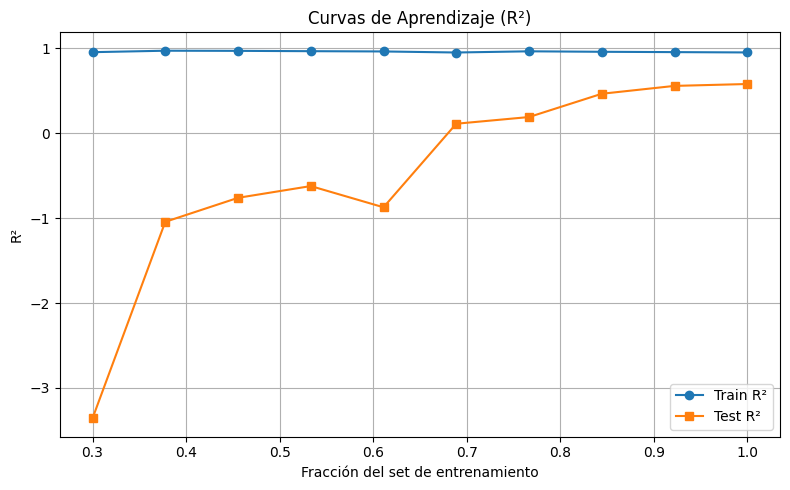

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.base import clone

train_sizes = np.linspace(0.3, 1.0, 10)  # Fracciones del set total
tscv = TimeSeriesSplit(n_splits=3)

train_scores = []
test_scores = []

for train_size_frac in train_sizes:
    train_scores_fold = []
    test_scores_fold = []

    for train_index, test_index in tscv.split(X):
        # Reducir el tamaño del set de entrenamiento
        n_train = int(len(train_index) * train_size_frac)
        if n_train < 10:  # evita sets muy pequeños
            continue

        X_train = X.iloc[train_index[:n_train]]
        y_train = y.iloc[train_index[:n_train]]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        model = clone(pipeline)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_scores_fold.append(r2_score(y_train, y_train_pred))
        test_scores_fold.append(r2_score(y_test, y_test_pred))

    train_scores.append(np.mean(train_scores_fold))
    test_scores.append(np.mean(test_scores_fold))

# === Graficar curvas de aprendizaje ===
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores, label='Train R²', marker='o')
plt.plot(train_sizes, test_scores, label='Test R²', marker='s')
plt.title("Curvas de Aprendizaje (R²)")
plt.xlabel("Fracción del set de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()